In [1]:
import torch
import numpy as np

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [23]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [24]:
class Neuron:
    def __init__(self, n_inputs):
        self.weights = torch.randn(n_inputs, 1, requires_grad=True)
        self.bias = torch.randn(1, 1, requires_grad=True)

    def forward(self, inputs):
        return inputs @ self.weights + self.bias

    def backward(self):
        self.dweights = self.weights.grad
        self.dbias = self.bias.grad

class SquaredLoss:
    def forward(self, y_pred, y_true):
        self.loss = (y_pred - y_true).pow(2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()

In [25]:
neuron = Neuron(4)
loss = SquaredLoss()
alpha = 0.05

for epoch in range(101):
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        loss.forward(y_pred, y_example)
        loss.backward()
        neuron.backward()
        with torch.no_grad():
            neuron.weights -= alpha * neuron.dweights
            neuron.bias -= alpha * neuron.dbias
            
        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: {loss.loss}")

neuron.weights

Epoch 0: 0.001362422714009881
Epoch 50: 0.0
Epoch 100: 0.0


tensor([[80.7262],
        [46.4226],
        [18.2388],
        [68.3044]], requires_grad=True)

3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [26]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [60]:
class Linear:
    def __init__(self, n_features, n_neurons): 
        
        self.weights = torch.randn(n_features, n_neurons, requires_grad=True)
        self.biases = torch.randn(n_neurons, requires_grad=True)
 
    def forward(self, inputs):
        return inputs @ self.weights + self.biases 

    def backward(self):
        self.dweights = self.weights.grad
        self.dbiases = self.biases.grad

class MSELoss:
    def forward(self, y_pred, y_true):
        self.loss = (y_pred.flatten() - y_true.flatten()).pow(2).mean()
        return self.loss

    def backward(self):
        self.loss.backward()
        
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs.clamp(min=0)
        return self.output

    def backward(self):
        self.dinputs = self.inputs.clamp(min=0)

In [97]:
lin_1 = Linear(1, 100)
relu = Activation_ReLU()
lin_2 = Linear(100, 1)

loss = MSELoss()
alpha = 0.05

y_pred = []
losses = []

for epoch in range(1001):
    out = lin_2.forward(relu.forward(lin_1.forward(X)))
    loss_1 = loss.forward(out, y)
    losses.append(loss_1.detach())
    
    if epoch % 100 == 0:
        print(f'epoch {epoch} loss {loss_1}')
        y_pred.append(out.flatten())

    loss.backward()
    lin_2.backward()
    lin_1.backward()

    with torch.no_grad():
        lin_1.weights -= alpha * lin_1.dweights
        lin_1.biases -= alpha * lin_1.dbiases
        lin_2.weights -= alpha * lin_2.dweights
        lin_2.biases -= alpha * lin_2.dbiases

    lin_1.weights.grad.zero_()
    lin_1.biases.grad.zero_()
    lin_2.weights.grad.zero_()
    lin_2.biases.grad.zero_()

epoch 0 loss 99.49938201904297
epoch 100 loss 0.22670185565948486
epoch 200 loss 0.1994979828596115
epoch 300 loss 0.19301708042621613
epoch 400 loss 0.1869528889656067
epoch 500 loss 0.18065530061721802
epoch 600 loss 0.17379118502140045
epoch 700 loss 0.1670558601617813
epoch 800 loss 0.16072817146778107
epoch 900 loss 0.1545661836862564
epoch 1000 loss 0.14841392636299133


<AxesSubplot:>

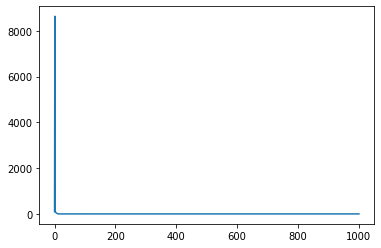

In [98]:
import seaborn as sns
losses = [i.item() for i in losses]
sns.lineplot(x=[i for i in range(1001)], y=losses)

<AxesSubplot:>

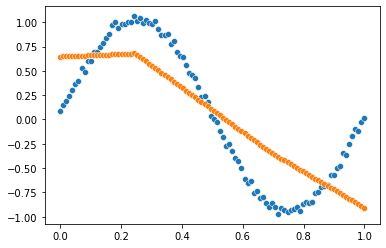

In [99]:
sns.scatterplot(x=X.flatten(), y=y.flatten())
sns.scatterplot(x=X.flatten(), y=y_pred[-1].detach().numpy())

## 3.2 Алгоритмы оптимизации в `torch.optim`

In [102]:
import torch.optim as optim

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [104]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

neuron = Neuron(4)
loss = SquaredLoss()
optimizer = torch.optim.SGD([neuron.weights, neuron.bias], lr=0.01)

for epoch in range(101):
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        loss.forward(y_pred, y_example)
        loss.backward()
        neuron.backward()
        with torch.no_grad():
            optimizer.step()
            
        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: {loss.loss}")

neuron.weights

Epoch 0: 882.4995727539062
Epoch 50: 2.0954757928848267e-09
Epoch 100: 2.0954757928848267e-09


tensor([[58.0738],
        [74.5463],
        [87.2157],
        [38.5551]], requires_grad=True)

3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [110]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

neuron = Neuron(4)
loss = SquaredLoss()
optimizer = torch.optim.Adam([neuron.weights, neuron.bias])

for epoch in range(1001):
    for x_example, y_example in zip(X, y):
        y_pred = neuron.forward(x_example)
        loss.forward(y_pred, y_example)
        loss.backward()
        neuron.backward()
        with torch.no_grad():
            optimizer.step()
        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: {loss.loss}")

neuron.weights.data

Epoch 0: 661.4866943359375
Epoch 50: 589.1421508789062
Epoch 100: 520.9338989257812
Epoch 150: 457.0640869140625
Epoch 200: 397.5238342285156
Epoch 250: 342.28656005859375
Epoch 300: 291.3374938964844
Epoch 350: 244.6587371826172
Epoch 400: 202.21505737304688
Epoch 450: 164.0000762939453
Epoch 500: 129.96942138671875
Epoch 550: 100.07955169677734
Epoch 600: 74.2537841796875
Epoch 650: 52.46665954589844
Epoch 700: 34.61881637573242
Epoch 750: 20.62600326538086
Epoch 800: 10.360179901123047
Epoch 850: 3.687096118927002
Epoch 900: 0.42171138525009155
Epoch 950: 0.34491604566574097
Epoch 1000: 3.1782898902893066


tensor([[13.2370],
        [57.2018],
        [48.2806],
        [15.6033]])

In [111]:
coef

array([21.34405568, 84.1586019 , 84.54193122, 11.69679564])

## 3.3 Построение сетей при помощи `torch.nn`

In [112]:
import torch.nn as nn

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [113]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [118]:
class NN_Model(torch.nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.lin_1 = torch.nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.lin_2 = torch.nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x):
        x = self.lin_1(x)
        x = self.activation(x)
        x = self.lin_2(x)
        return x

    
model = NN_Model()
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.MSELoss()

for epoch in range(101):

    y_pred = model(X)
    data_loss = loss(y_pred.flatten(), y.flatten())
    data_loss.backward()

    with torch.no_grad():
        optimizer.step()
    
    model.zero_grad()
            
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: {data_loss.item()}")

Epoch 0: 0.5848522782325745
Epoch 50: 0.27085408568382263
Epoch 100: 0.18988941609859467


3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [120]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [121]:
model_sequential = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)
optimizer = torch.optim.Adam(model_sequential.parameters())
loss = torch.nn.MSELoss()

for epoch in range(101):

    y_pred = model_sequential(X)
    data_loss = loss(y_pred, y)
    data_loss.backward()

    with torch.no_grad():
        optimizer.step()
        
    model_sequential.zero_grad()
            
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: {data_loss.item()}")

Epoch 0: 0.558324933052063
Epoch 50: 0.29787924885749817
Epoch 100: 0.20251022279262543


## 3.4. Datasets and dataloaders

In [122]:
from torch.utils.data import Dataset, DataLoader

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [2]:
class SinDataset(Dataset):
  def __init__(self):
    pass

  def __len__(self):
    pass

  def __getitem__(self, idx):
    pass

In [123]:
class SinDataset(Dataset):
    def __init__(self, inp: torch.Tensor, target: torch.Tensor):
        self.inp, self.tgt = inp, target

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, idx):
        return self.inp[idx], self.tgt[idx]

In [124]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())
dataset = SinDataset(X, y)

In [126]:
model = NN_Model()
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.MSELoss()


for i in range(101):
    for x, y in DataLoader(dataset, batch_size=10):
        y_pred = model(x)
        data_loss = loss(y_pred.flatten(), y.flatten())
        data_loss.backward()


        optimizer.step()
        optimizer.zero_grad()

    if i % 50 == 0:
        print(f"Epoch {i}: {data_loss.item()}")

Epoch 0: 0.054337769746780396
Epoch 50: 0.27001649141311646
Epoch 100: 0.2641444802284241


3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


In [129]:
import pandas as pd

class DiamondsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, target: pd.Series):
        self.data = torch.tensor(data.values).float()
        self.target = torch.tensor(target.values).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

df = pd.read_csv("diamonds.csv", index_col=0)
dataset = DiamondsDataset(df.drop(columns=["cut", "color", "clarity", "price"], axis=1), data['price'])

In [137]:
train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.7), int(len(dataset) * 0.3)])

In [143]:
model = torch.nn.Sequential(
    torch.nn.Linear(6, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1)
)

optimizer = torch.optim.Adam(model.parameters(), 0.001)
loss = torch.nn.MSELoss()
losses = []


for i in range(11):
    epoch_loss = 0
    for j, (x, y) in enumerate(DataLoader(train_data, batch_size=256), 1):
        y_pred = model(x)
        data_loss = loss(y_pred.flatten(), y.flatten())
        data_loss.backward()
        epoch_loss += data_loss.item()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(epoch_loss / j)
    if i % 2 == 0:
        print(f"Epoch {i}: {epoch_loss / j}")

Epoch 0: 27046269.91891892
Epoch 2: 15257187.317567568
Epoch 4: 14740890.702702703
Epoch 6: 13770236.324324325
Epoch 8: 12282285.202702703
Epoch 10: 10281003.537162162


In [148]:
test_pred = model(test_data[:][0])
test_loss = loss(test_pred.flatten(), test_data[:][1].flatten()).item()
print(f"Test loss: {test_loss}")

Test loss: 9479196.0


3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [149]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.X = data.drop(columns=["price"])
        self.transform = transform
        self.y = data.y

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.X.iloc[idx], self.y.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [160]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop

    def __call__(self, df):
        X, y = df
        X = X.iloc[:, [j for j, c in enumerate(X.columns) if j != i]]
        return X.values, y

In [161]:
class ToTensorTransform:
    def __call__(self, df):
        X, y = df
        return torch.tensor(list(X)).float(), torch.tensor(y).float()

In [166]:
from torchvision import transforms

drop = DropColsTransform(drop=[0, 4, 5])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(data, transforms.Compose([drop, to_tensor]))